In [12]:
!pip install librosa soundfile tensorflow scikit-learn tqdm kaggle gdown joblib -q

In [13]:
import os
import numpy as np
import librosa
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# ============================================================================
# CELL 3: Download RAVDESS Dataset (Popular Speech Emotion Dataset) - FIX APPLIED
# ============================================================================
"""
RAVDESS Dataset:
- 24 actors (12 male, 12 female)
- 8 emotions: neutral, calm, happy, sad, angry, fearful, disgust, surprised
- 1440 speech files
"""

def download_ravdess():
    """Download and extract RAVDESS dataset"""
    dataset_path = "/content/dataset"
    zip_path = "/content/ravdess.zip"

    # Create dataset directory
    os.makedirs(dataset_path, exist_ok=True)

    # Download using wget (Zenodo link for the combined zip)
    print("Downloading RAVDESS dataset...")

    # RAVDESS Audio_Speech_Actors_01-24 (The main combined zip)
    url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"

    # Download
    os.system(f"wget --progress=bar:force:noscroll {url} -O {zip_path}")

    # --- FIX: Check for successful download before extraction ---
    if not os.path.exists(zip_path) or os.path.getsize(zip_path) < 1024 * 1024 * 10: # Check size (e.g., > 10MB)
        print(f"\n❌ Error: Download failed or file is too small ({os.path.getsize(zip_path) // 1024**2} MB). Retrying or check URL.")
        # Attempt to clean up and exit gracefully if download fails
        if os.path.exists(zip_path):
            os.remove(zip_path)
        return dataset_path

    # Extract
    print("Extracting...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        os.remove(zip_path) # Clean up the zip file
    except zipfile.BadZipFile:
        print("\n❌ Error: Failed to extract. The downloaded file is a Bad Zip File. Please try running the cell again.")
        # Clean up corrupted download
        if os.path.exists(zip_path):
            os.remove(zip_path)
        return dataset_path

    # Organize files by emotion
    organize_ravdess_by_emotion(dataset_path)

    return dataset_path

def organize_ravdess_by_emotion(base_path):
    """
    RAVDESS filename format: 03-01-06-01-02-01-12.wav
    Position 3 (index 2) = emotion:
    01 = neutral, 02 = calm, 03 = happy, 04 = sad,
    05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
    """
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    # Create emotion folders
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(base_path, emotion), exist_ok=True)

    # Move files
    print("Organizing files by emotion...")
    moved_count = 0

    # Walk through the extracted Actor folders
    for root, dirs, files in os.walk(base_path, topdown=False):
        for file in files:
            if file.endswith('.wav'):
                try:
                    # Extract emotion code
                    parts = file.split('-')
                    emotion_code = parts[2]
                    emotion_label = emotion_map.get(emotion_code)

                    if emotion_label:
                        src = os.path.join(root, file)
                        dst = os.path.join(base_path, emotion_label, file)

                        # --- FIX: Use shutil.move instead of shutil.copy2 ---
                        shutil.move(src, dst)
                        moved_count += 1
                except:
                    pass

        # Clean up empty Actor folders immediately after processing
        # This handles the deletion of the original 'Actor_xx' folders
        if root != base_path and root.startswith(os.path.join(base_path, 'Actor_')):
            try:
                shutil.rmtree(root)
            except OSError as e:
                # Handle case where folder might not be empty or has permission issues
                print(f"Could not remove directory {root}: {e}")


    print(f"Organized {moved_count} files")

    # Clean up any remaining empty Actor folders that might be in the base_path
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item.startswith('Actor_'):
             shutil.rmtree(item_path)


# Download dataset
dataset_path = download_ravdess()
print(f"Dataset ready at: {dataset_path}")

# Show dataset statistics
print("\nDataset Statistics:")
for emotion in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion)
    if os.path.isdir(emotion_path):
        count = len([f for f in os.listdir(emotion_path) if f.endswith('.wav')])
        print(f"{emotion}: {count} files")

Extracting...
Organizing files by emotion...
Organized 2880 files
Dataset ready at: /content/dataset

Dataset Statistics:
calm: 192 files
happy: 192 files
sad: 192 files
angry: 192 files
disgust: 192 files
surprised: 192 files
neutral: 96 files
fearful: 192 files


In [15]:
SAMPLE_RATE = 22050
DURATION = 3.0
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

# Training
TEST_SIZE = 0.15
VAL_SIZE = 0.15
BATCH_SIZE = 32
EPOCHS = 80
RANDOM_STATE = 42
LSTM_UNITS = 128
DROPOUT_RATE = 0.4

# Output paths
MODEL_PATH = "/content/emotion_model.h5"
ENCODER_PATH = "/content/label_encoder.joblib"
SCALER_PATH = "/content/feature_scaler.joblib"

In [16]:
def load_audio(path, sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    try:
        audio, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
    except Exception as e:
        # Fallback with soundfile
        try:
            audio, file_sr = sf.read(path)
            audio = librosa.to_mono(audio.T) if audio.ndim > 1 else audio
            if file_sr != sr:
                audio = librosa.resample(audio, orig_sr=file_sr, target_sr=sr)
        except:
            return None

    # Pad or truncate
    if len(audio) > SAMPLES_PER_TRACK:
        audio = audio[:SAMPLES_PER_TRACK]
    else:
        pad_len = SAMPLES_PER_TRACK - len(audio)
        audio = np.pad(audio, (0, pad_len), mode='constant')

    return audio

def extract_features(signal, sr=SAMPLE_RATE, n_mfcc=N_MFCC,
                    n_fft=N_FFT, hop_length=HOP_LENGTH):
    """Extract comprehensive audio features"""

    # MFCC and delta
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc,
                                n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    delta_mfcc = librosa.feature.delta(mfcc.T).T

    # Chroma features
    stft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr).T

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft,
                                         hop_length=hop_length)
    mel_db = librosa.power_to_db(mel).T

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr).T

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=signal, sr=sr).T

    # Align all features to same time dimension
    min_t = min(mfcc.shape[0], delta_mfcc.shape[0], chroma.shape[0],
                mel_db.shape[0], contrast.shape[0], tonnetz.shape[0])

    features = np.concatenate([
        mfcc[:min_t],
        delta_mfcc[:min_t],
        chroma[:min_t],
        mel_db[:min_t],
        contrast[:min_t],
        tonnetz[:min_t]
    ], axis=1)

    return features


In [17]:
def load_dataset(dataset_path):
    """Load all audio files and extract features"""
    features = []
    labels = []

    label_names = sorted([d for d in os.listdir(dataset_path)
                         if os.path.isdir(os.path.join(dataset_path, d))])

    print(f"Found {len(label_names)} emotion classes: {label_names}")

    for label in label_names:
        folder = os.path.join(dataset_path, label)
        files = [f for f in os.listdir(folder) if f.endswith('.wav')]

        print(f"\nProcessing {label}...")
        for file in tqdm(files):
            path = os.path.join(folder, file)
            try:
                signal = load_audio(path)
                if signal is not None:
                    feat = extract_features(signal)
                    features.append(feat)
                    labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

    print(f"\nTotal samples loaded: {len(features)}")
    return features, labels

# Load data
print("Loading dataset...")
features_list, labels_list = load_dataset(dataset_path)

# ============================================================================
# CELL 7: Prepare Data for Training
# ============================================================================
def pad_features(feature_list):
    """Pad features to same length"""
    max_t = max(f.shape[0] for f in feature_list)
    feat_dim = feature_list[0].shape[1]
    N = len(feature_list)

    X = np.zeros((N, max_t, feat_dim), dtype=np.float32)
    for i, f in enumerate(feature_list):
        t = f.shape[0]
        X[i, :t, :] = f if t <= max_t else f[:max_t, :]

    return X


Loading dataset...
Found 8 emotion classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Processing angry...


100%|██████████| 192/192 [00:51<00:00,  3.75it/s]



Processing calm...


100%|██████████| 192/192 [00:35<00:00,  5.46it/s]



Processing disgust...


100%|██████████| 192/192 [00:34<00:00,  5.59it/s]



Processing fearful...


100%|██████████| 192/192 [00:32<00:00,  5.87it/s]



Processing happy...


100%|██████████| 192/192 [00:33<00:00,  5.69it/s]



Processing neutral...


100%|██████████| 96/96 [00:16<00:00,  5.95it/s]



Processing sad...


100%|██████████| 192/192 [00:33<00:00,  5.80it/s]



Processing surprised...


100%|██████████| 192/192 [00:32<00:00,  5.96it/s]


Total samples loaded: 1440


In [18]:
print("Padding features...")
X = pad_features(features_list)
print(f"Feature shape: {X.shape} (samples, timesteps, features)")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_list)
num_classes = len(le.classes_)
print(f"\nClasses: {list(le.classes_)}")
print(f"Number of classes: {num_classes}")

# Scale features
print("\nScaling features...")
N, T, D = X.shape
X_2d = X.reshape(-1, D)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2d).reshape(N, T, D)

# Train/Val/Test split
print("\nSplitting data...")
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

val_rel = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_rel,
    random_state=RANDOM_STATE, stratify=y_trainval
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Padding features...
Feature shape: (1440, 130, 233) (samples, timesteps, features)

Classes: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]
Number of classes: 8

Scaling features...

Splitting data...
Train: 1008 samples
Val: 216 samples
Test: 216 samples


In [19]:
def build_emotion_model(input_shape, num_classes):
    """Build dual-layer LSTM model"""
    model = Sequential([
        # First LSTM layer
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),

        # Second LSTM layer
        LSTM(LSTM_UNITS // 2, return_sequences=False),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [20]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_emotion_model(input_shape, num_classes)
model.summary()

# ============================================================================
# CELL 9: Train Model
# ============================================================================
# Callbacks
checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

# Train
print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 128)       │       185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,024 (945.41 KB)

 Trainable params: 241,640 (943.91 KB)

 Non-trainable params: 384 (1.50 KB)


Starting training...

Epoch 1/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1310 - loss: 2.3664
Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.1320 - loss: 2.3612 - val_accuracy: 0.2778 - val_loss: 2.0130 - learning_rate: 0.0010
Epoch 2/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1849 - loss: 2.0681
Epoch 2: val_accuracy improved from 0.27778 to 0.30556, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1863 - loss: 2.0652 - val_accuracy: 0.3056 - val_loss: 1.9599 - learning_rate: 0.0010
Epoch 3/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2564 - loss: 1.8898
Epoch 3: val_accuracy improved from 0.30556 to 0.34259, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2567 - loss: 1.8899 - val_accuracy: 0.3426 - val_loss: 1.8710 - learning_rate: 0.0010
Epoch 4/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2780 - loss: 1.8316
Epoch 4: val_accuracy did not improve from 0.34259
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2781 - loss: 1.8337 - val_accuracy: 0.3241 - val_loss: 1.8125 - learning_rate: 0.0010
Epoch 5/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3165 - loss: 1.7916
Epoch 5: val_accuracy improved from 0.34259 to 0.38426, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3169 - loss: 1.7917 - val_accuracy: 0.3843 - val_loss: 1.6939 - learning_rate: 0.0010
Epoch 6/80
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3457 - loss: 1.6900
Epoch 6: val_accuracy improved from 0.38426 to 0.40278, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3460 - loss: 1.6924 - val_accuracy: 0.4028 - val_loss: 1.6489 - learning_rate: 0.0010
Epoch 7/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3159 - loss: 1.7258
Epoch 7: val_accuracy improved from 0.40278 to 0.42593, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3175 - loss: 1.7251 - val_accuracy: 0.4259 - val_loss: 1.5440 - learning_rate: 0.0010
Epoch 8/80
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3877 - loss: 1.5933
Epoch 8: val_accuracy improved from 0.42593 to 0.46296, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3878 - loss: 1.5929 - val_accuracy: 0.4630 - val_loss: 1.4489 - learning_rate: 0.0010
Epoch 9/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3803 - loss: 1.5716
Epoch 9: val_accuracy did not improve from 0.46296
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3806 - loss: 1.5725 - val_accuracy: 0.4537 - val_loss: 1.4439 - learning_rate: 0.0010
Epoch 10/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4149 - loss: 1.5129
Epoch 10: val_accuracy improved from 0.46296 to 0.46759, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4144 - loss: 1.5140 - val_accuracy: 0.4676 - val_loss: 1.4369 - learning_rate: 0.0010
Epoch 11/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4616 - loss: 1.4839
Epoch 11: val_accuracy did not improve from 0.46759
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4611 - loss: 1.4843 - val_accuracy: 0.4583 - val_loss: 1.3546 - learning_rate: 0.0010
Epoch 12/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4543 - loss: 1.4340
Epoch 12: val_accuracy improved from 0.46759 to 0.50463, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4529 - loss: 1.4325 - val_accuracy: 0.5046 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 13/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4605 - loss: 1.3743
Epoch 13: val_accuracy did not improve from 0.50463
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4608 - loss: 1.3746 - val_accuracy: 0.4954 - val_loss: 1.3178 - learning_rate: 0.0010
Epoch 14/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5293 - loss: 1.2631
Epoch 14: val_accuracy improved from 0.50463 to 0.51852, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5279 - loss: 1.2642 - val_accuracy: 0.5185 - val_loss: 1.2903 - learning_rate: 0.0010
Epoch 15/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4896 - loss: 1.3011
Epoch 15: val_accuracy did not improve from 0.51852
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4898 - loss: 1.3008 - val_accuracy: 0.4630 - val_loss: 1.3964 - learning_rate: 0.0010
Epoch 16/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5115 - loss: 1.2168
Epoch 16: val_accuracy did not improve from 0.51852
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5113 - loss: 1.2176 - val_accuracy: 0.5046 - val_loss: 1.2975 - learning_rate: 0.0010
Epoch 17/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4934 - loss: 1.2337
Epoch 17: val_accuracy did not improve from 0.51852
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4961 - loss: 1.2304 - val_accuracy: 0.4954 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 18/80
32/32 ━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6364 - loss: 0.9052 - val_accuracy: 0.5509 - val_loss: 1.2913 - learning_rate: 5.0000e-04
Epoch 22/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6447 - loss: 0.8851
Epoch 22: val_accuracy improved from 0.55093 to 0.56944, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6446 - loss: 0.8851 - val_accuracy: 0.5694 - val_loss: 1.3631 - learning_rate: 5.0000e-04
Epoch 23/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6602 - loss: 0.8741
Epoch 23: val_accuracy did not improve from 0.56944
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6612 - loss: 0.8718 - val_accuracy: 0.5694 - val_loss: 1.2487 - learning_rate: 5.0000e-04
Epoch 24/80
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6896 - loss: 0.7932
Epoch 24: val_accuracy improved from 0.56944 to 0.57407, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6898 - loss: 0.7922 - val_accuracy: 0.5741 - val_loss: 1.3420 - learning_rate: 5.0000e-04
Epoch 25/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7089 - loss: 0.7707
Epoch 25: val_accuracy improved from 0.57407 to 0.57870, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7083 - loss: 0.7702 - val_accuracy: 0.5787 - val_loss: 1.4018 - learning_rate: 5.0000e-04
Epoch 26/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7139 - loss: 0.7101
Epoch 26: val_accuracy did not improve from 0.57870
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7135 - loss: 0.7114 - val_accuracy: 0.5741 - val_loss: 1.3304 - learning_rate: 5.0000e-04
Epoch 27/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7264 - loss: 0.7253
Epoch 27: val_accuracy did not improve from 0.57870
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7263 - loss: 0.7252 - val_accuracy: 0.5787 - val_loss: 1.3616 - learning_rate: 5.0000e-04
Epoch 28/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7290 - loss: 0.6959
Epoch 28: val_accuracy did not improve from 0.57870

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7290 - loss: 0.6971 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7534 - loss: 0.6915 - val_accuracy: 0.6111 - val_loss: 1.3549 - learning_rate: 2.5000e-04
Epoch 30/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7579 - loss: 0.6082
Epoch 30: val_accuracy improved from 0.61111 to 0.63426, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7572 - loss: 0.6099 - val_accuracy: 0.6343 - val_loss: 1.2970 - learning_rate: 2.5000e-04
Epoch 31/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7942 - loss: 0.5759
Epoch 31: val_accuracy did not improve from 0.63426
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7915 - loss: 0.5789 - val_accuracy: 0.6157 - val_loss: 1.4484 - learning_rate: 2.5000e-04
Epoch 32/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7739 - loss: 0.5525
Epoch 32: val_accuracy did not improve from 0.63426
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7723 - loss: 0.5547 - val_accuracy: 0.6296 - val_loss: 1.4353 - learning_rate: 2.5000e-04
Epoch 33/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8050 - loss: 0.5271
Epoch 33: val_accuracy did not improve from 0.63426

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8023 - loss: 0.5301 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8165 - loss: 0.4982 - val_accuracy: 0.6481 - val_loss: 1.4974 - learning_rate: 1.2500e-04
Epoch 36/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8007 - loss: 0.4983
Epoch 36: val_accuracy did not improve from 0.64815
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8005 - loss: 0.4983 - val_accuracy: 0.6296 - val_loss: 1.4599 - learning_rate: 1.2500e-04
Epoch 37/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8097 - loss: 0.4791
Epoch 37: val_accuracy improved from 0.64815 to 0.65278, saving model to /content/emotion_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8110 - loss: 0.4797 - val_accuracy: 0.6528 - val_loss: 1.4862 - learning_rate: 1.2500e-04
Epoch 38/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8028 - loss: 0.5338
Epoch 38: val_accuracy improved from 0.65278 to 0.67130, saving model to /content/emotion_model.h5



Epoch 38: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8032 - loss: 0.5326 - val_accuracy: 0.6713 - val_loss: 1.4490 - learning_rate: 1.2500e-04
Epoch 39/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8363 - loss: 0.4569
Epoch 39: val_accuracy did not improve from 0.67130
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8365 - loss: 0.4566 - val_accuracy: 0.6667 - val_loss: 1.4444 - learning_rate: 6.2500e-05
Epoch 40/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8376 - loss: 0.4133
Epoch 40: val_accuracy did not improve from 0.67130
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8377 - loss: 0.4141 - val_accuracy: 0.6713 - val_loss: 1.4517 - learning_rate: 6.2500e-05
Epoch 41/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8643 - loss: 0.4208
Epoch 41: val_accuracy did not improve from 0.67130
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8642 - loss: 0.4211 - v

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8174 - loss: 0.4420 - val_accuracy: 0.6759 - val_loss: 1.4752 - learning_rate: 6.2500e-05
Epoch 43/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8085 - loss: 0.4621
Epoch 43: val_accuracy did not improve from 0.67593

Epoch 43: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8093 - loss: 0.4615 - val_accuracy: 0.6667 - val_loss: 1.4781 - learning_rate: 6.2500e-05
Epoch 44/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8591 - loss: 0.3646
Epoch 44: val_accuracy did not improve from 0.67593
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8587 - loss: 0.3656 - val_accuracy: 0.6667 - val_loss: 1.4702 - learning_rate: 3.1250e-05
Epoch 45/80
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8165 - loss: 0.4419
Epoch 45: val_accuracy did not improve from 0.67593
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8187 - loss: 0.4379 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8741 - loss: 0.4112 - val_accuracy: 0.6806 - val_loss: 1.5055 - learning_rate: 7.8125e-06
Epoch 55/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8423 - loss: 0.4198
Epoch 55: val_accuracy did not improve from 0.68056
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8428 - loss: 0.4178 - val_accuracy: 0.6806 - val_loss: 1.5036 - learning_rate: 7.8125e-06
Epoch 56/80
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8485 - loss: 0.3943
Epoch 56: val_accuracy did not improve from 0.68056
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8483 - loss: 0.3939 - val_accuracy: 0.6759 - val_loss: 1.5053 - learning_rate: 7.8125e-06
Epoch 57/80
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8630 - loss: 0.3962
Epoch 57: val_accuracy did not improve from 0.68056
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8631 - loss: 0.3959 - val_accuracy: 0.6759 - val_loss: 1.5013 - learning_rate: 7.8125e-06
Epoch 58/8

In [21]:
model = load_model(MODEL_PATH)

# Evaluate on test set
print("\n" + "="*50)
print("Evaluating on test set...")
print("="*50)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Evaluating on test set...

Test Loss: 1.3462
Test Accuracy: 0.6157
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.71      0.65        28
        calm       0.87      0.90      0.88        29
     disgust       0.79      0.76      0.77        29
     fearful       0.61      0.79      0.69        29
       happy       0.46      0.41      0.44        29
     neutral       0.29      0.29      0.29        14
         sad       0.42      0.28      0.33        29
   surprised       0.67      0.62      0.64        29

    accuracy                           0.62       216
   macro avg       0.59      0.59      0.59       216
weighted avg       0.61      0.62      0.61       216



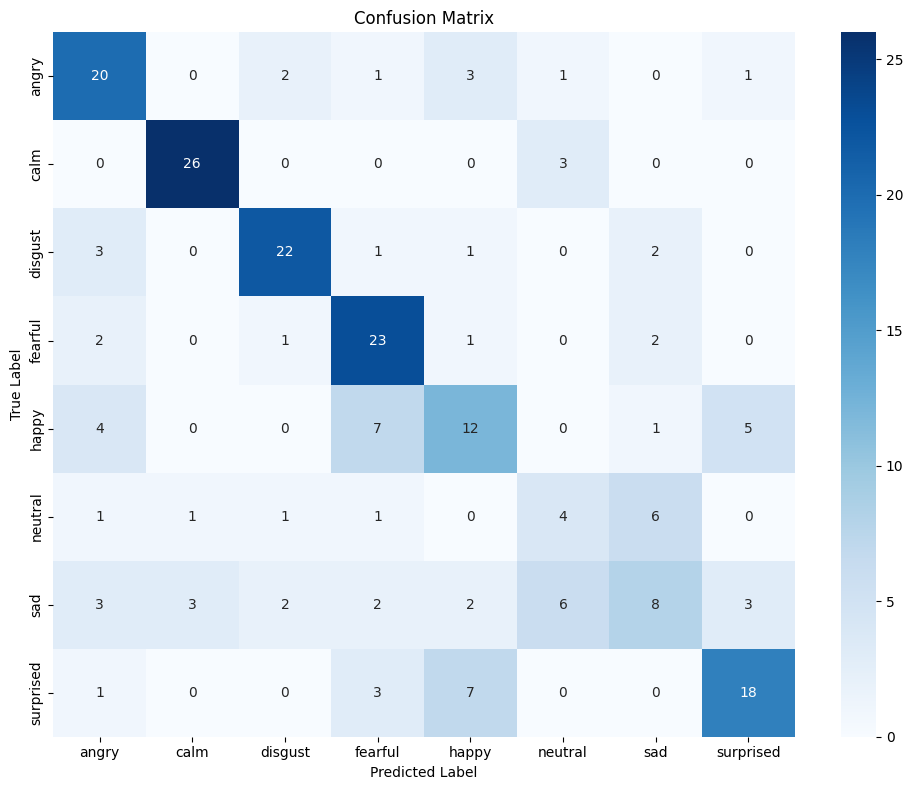

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

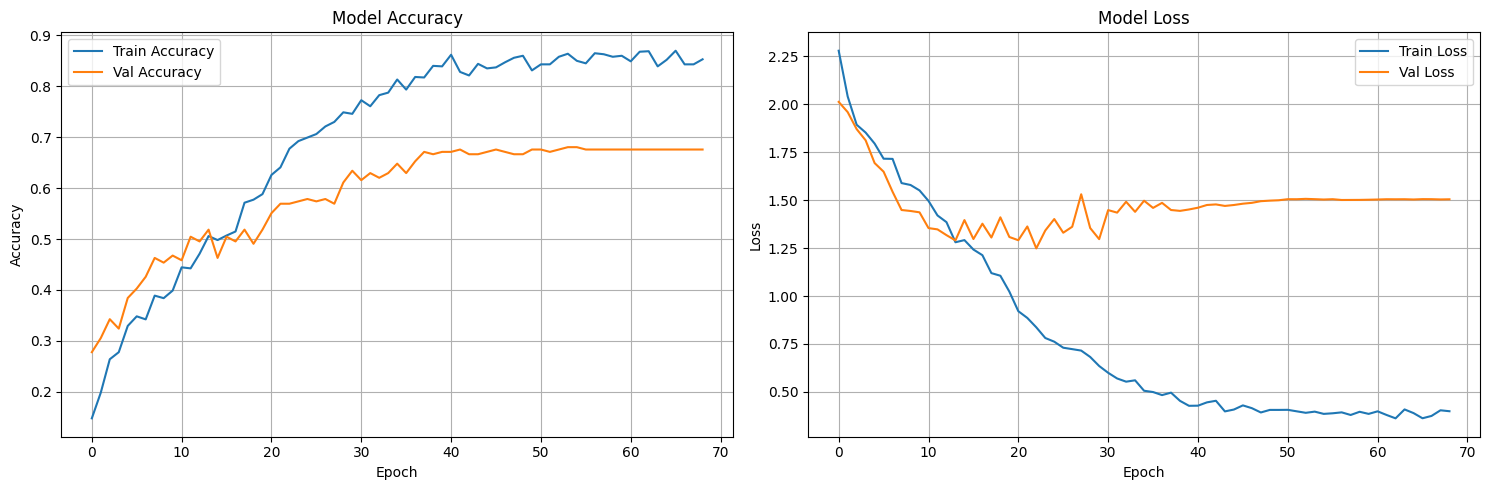

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
joblib.dump(le, ENCODER_PATH)
joblib.dump(scaler, SCALER_PATH)

print("\n" + "="*50)
print("All files saved successfully!")
print("="*50)
print(f"\nModel: {MODEL_PATH}")
print(f"Label Encoder: {ENCODER_PATH}")
print(f"Feature Scaler: {SCALER_PATH}")


All files saved successfully!

Model: /content/emotion_model.h5
Label Encoder: /content/label_encoder.joblib
Feature Scaler: /content/feature_scaler.joblib


Generating Mel-Spectrogram Visualizations...


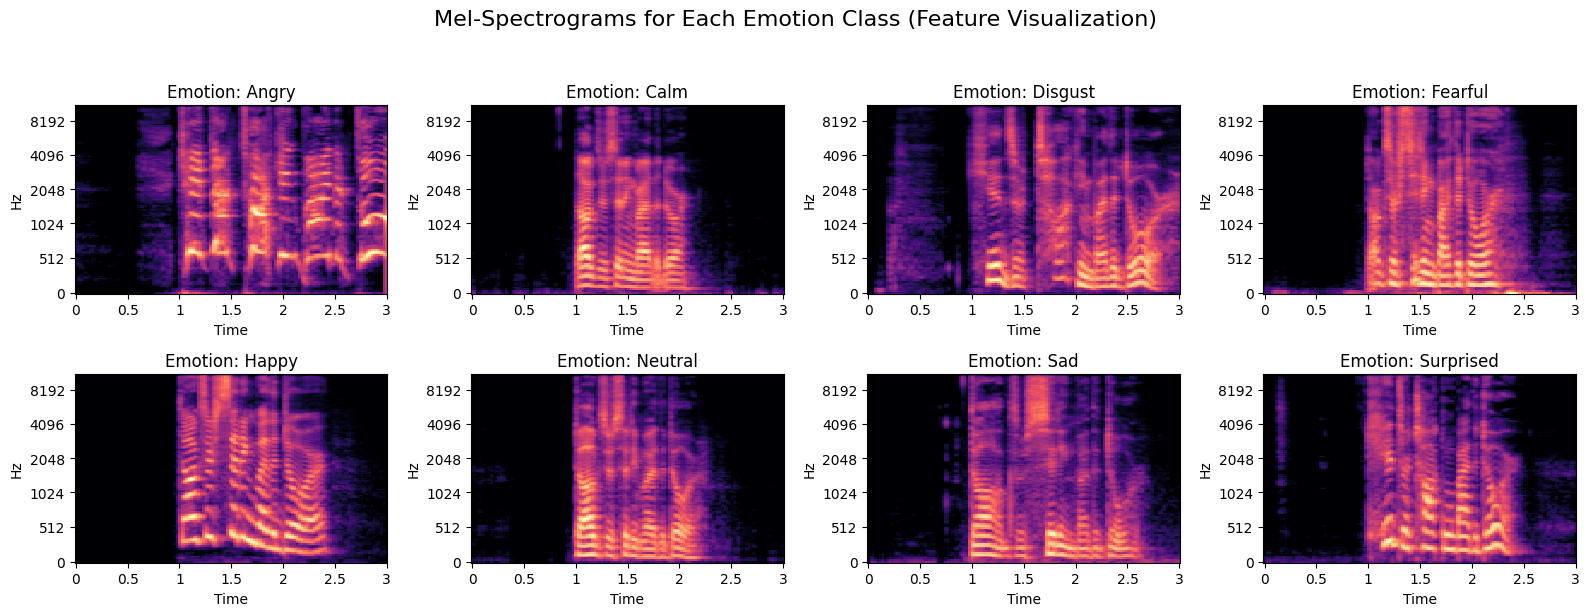

In [26]:
# --- New Cell for Mel-Spectrogram Visualization (Requires matplotlib/librosa imports from Cell 2) ---

def visualize_emotion_spectrograms(dataset_path, le, sr=SAMPLE_RATE, duration=DURATION):
    """Plots the Mel-Spectrogram for one example of each emotion class."""

    emotion_samples = {}

    # Collect one file path for each emotion
    for emotion in le.classes_:
        emotion_path = os.path.join(dataset_path, emotion)
        files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]
        if files:
            # Get the first file found for this emotion
            emotion_samples[emotion] = os.path.join(emotion_path, files[0])

    # Plotting
    num_emotions = len(emotion_samples)

    # Determine grid size (e.g., 4x2 for 8 emotions, or 3x3 for 9)
    cols = 4 if num_emotions > 4 else num_emotions
    rows = int(np.ceil(num_emotions / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten() if rows > 1 else [axes]

    print("Generating Mel-Spectrogram Visualizations...")

    for i, (emotion, path) in enumerate(emotion_samples.items()):

        # Load audio and compute Mel-Spectrogram
        signal = load_audio(path, sr=sr, duration=duration)
        if signal is not None:
            mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
            mel_db = librosa.power_to_db(mel, ref=np.max)

            # Plot
            librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i])
            axes[i].set_title(f'Emotion: {emotion.capitalize()}', fontsize=12)

    # Hide any unused subplots
    for i in range(num_emotions, rows * cols):
        fig.delaxes(axes[i])

    plt.suptitle('Mel-Spectrograms for Each Emotion Class (Feature Visualization)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('/content/emotion_spectrograms.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the function
visualize_emotion_spectrograms(dataset_path, le)